## Benchmark Charts + Analysis

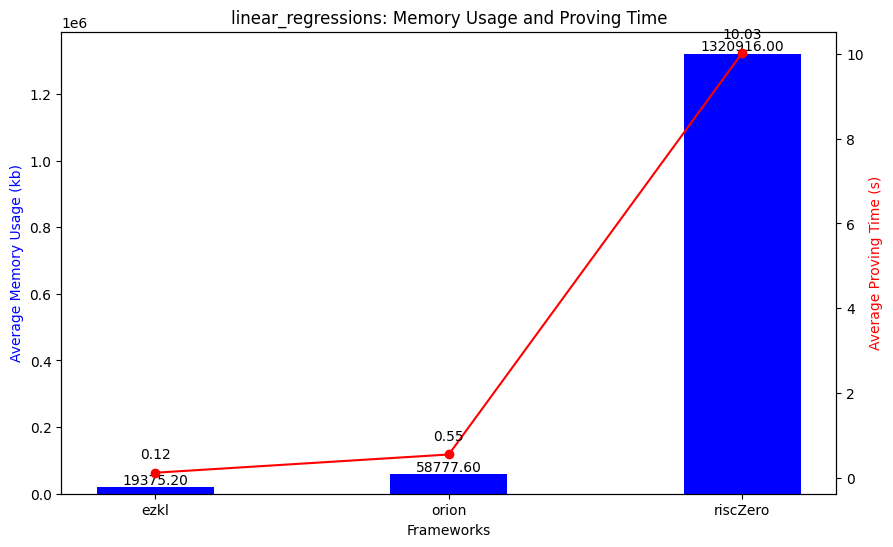

linear_regressions Results:

Proving Time Speedup:
EZKL is approximately 4.65 times faster than Orion.
EZKL is about 85.13 times faster than RISC0.

Memory Usage Reduction:
EZKL uses roughly 67.04% less memory compared to Orion.
EZKL's memory usage is about 98.53% less than that of RISC0.



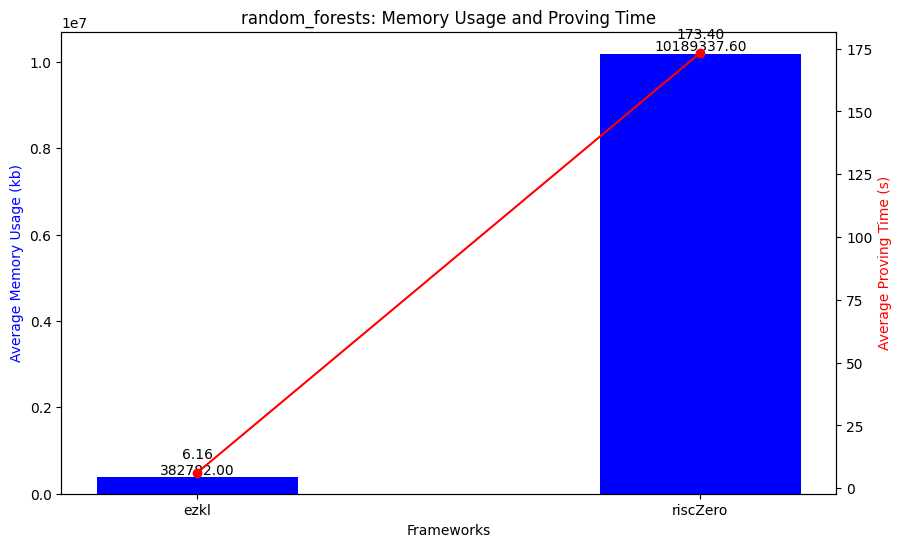

random_forests Results:

Proving Time Speedup:
EZKL is about 28.14 times faster than RISC0.

Memory Usage Reduction:
EZKL's memory usage is about 96.24% less than that of RISC0.



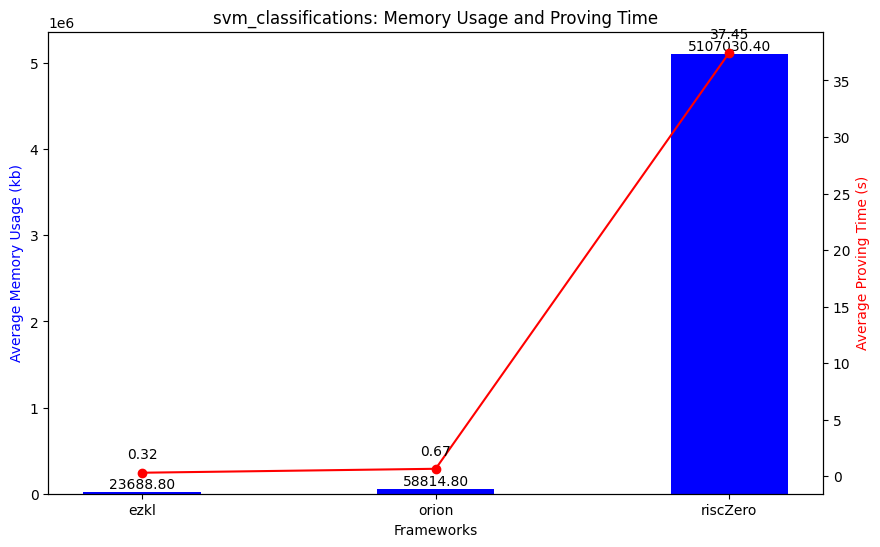

svm_classifications Results:

Proving Time Speedup:
EZKL is approximately 2.09 times faster than Orion.
EZKL is about 117.59 times faster than RISC0.

Memory Usage Reduction:
EZKL uses roughly 59.72% less memory compared to Orion.
EZKL's memory usage is about 99.54% less than that of RISC0.



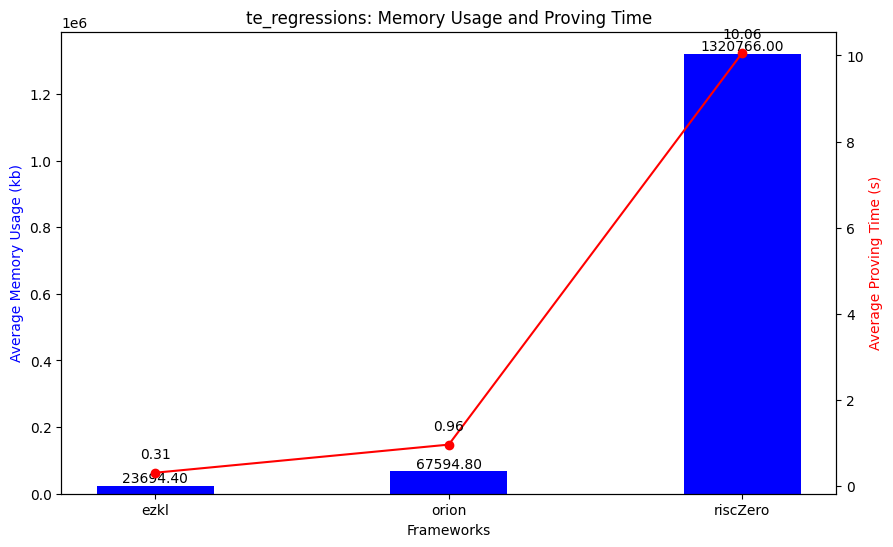

te_regressions Results:

Proving Time Speedup:
EZKL is approximately 3.12 times faster than Orion.
EZKL is about 32.65 times faster than RISC0.

Memory Usage Reduction:
EZKL uses roughly 64.95% less memory compared to Orion.
EZKL's memory usage is about 98.21% less than that of RISC0.



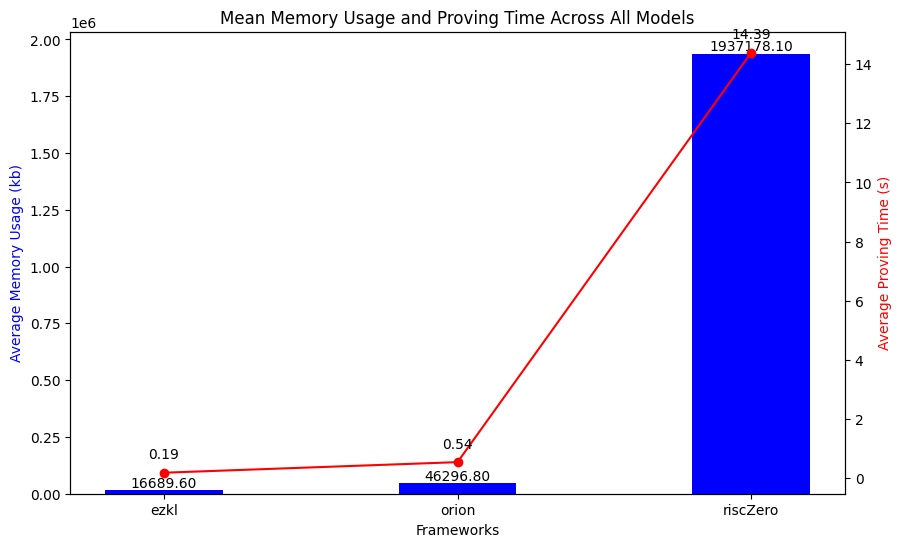

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import json

def load_data(filepath):
    try:
        with open(filepath) as f:
            return json.load(f)
    except FileNotFoundError:
        print(f"File not found: {filepath}")
        return None

def preprocess_data(data, model):
    frameworks = ['ezkl', 'riscZero'] if model == 'random_forests' else ['ezkl', 'orion', 'riscZero']
    memory_usage = {framework: np.mean([int(mu.replace('kb', '')) for mu in data[model][framework]['memoryUsage']])
                    for framework in frameworks}
    proving_time = {framework: np.mean([float(pt.replace('s', '')) for pt in data[model][framework]['provingTime']])
                    for framework in frameworks}
    return memory_usage, proving_time

def plot_data(frameworks, memory_usage, proving_time, title):
    # Filter frameworks to those present in both memory_usage and proving_time
    valid_frameworks = [fw for fw in frameworks if fw in memory_usage and fw in proving_time]

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Prepare data for valid frameworks only
    valid_memory_usage = [memory_usage[fw] for fw in valid_frameworks]
    valid_proving_time = [proving_time[fw] for fw in valid_frameworks]

    bars = ax1.bar(np.arange(len(valid_frameworks)), valid_memory_usage, color='b', width=0.4, align='center')
    ax1.set_xlabel('Frameworks')
    ax1.set_ylabel('Average Memory Usage (kb)', color='b')
    ax1.set_xticks(np.arange(len(valid_frameworks)))
    ax1.set_xticklabels(valid_frameworks)

    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height, f'{height:.2f}', ha='center', va='bottom', color='black')

    ax2 = ax1.twinx()
    ax2.plot(np.arange(len(valid_frameworks)), valid_proving_time, color='r', marker='o')
    ax2.set_ylabel('Average Proving Time (s)', color='r')

    for i, txt in enumerate(valid_proving_time):
        ax2.annotate(f'{txt:.2f}', (i, txt), textcoords="offset points", xytext=(0,10), ha='center')

    plt.title(title)
    plt.show()


def calculate_performance(memory_usage, proving_time):
    speedup_risczero = proving_time['riscZero'] / proving_time['ezkl']
    reduction_risczero = (memory_usage['riscZero'] - memory_usage['ezkl']) * 100 / memory_usage['riscZero']

    if 'orion' in memory_usage:
        speedup_orion = proving_time['orion'] / proving_time['ezkl']
        reduction_orion = (memory_usage['orion'] - memory_usage['ezkl']) * 100 / memory_usage['orion']
        return speedup_orion, reduction_orion, speedup_risczero, reduction_risczero
    else:
        return None, None, speedup_risczero, reduction_risczero

def print_performance(model, performance):
    speedup_orion, reduction_orion, speedup_risczero, reduction_risczero = performance
    statement = f"{model} Results:\n\nProving Time Speedup:\n"
    if speedup_orion is not None:
        statement += f"EZKL is approximately {speedup_orion:.2f} times faster than Orion.\n"
    statement += f"EZKL is about {speedup_risczero:.2f} times faster than RISC0.\n\nMemory Usage Reduction:\n"
    if reduction_orion is not None:
        statement += f"EZKL uses roughly {reduction_orion:.2f}% less memory compared to Orion.\n"
    statement += f"EZKL's memory usage is about {reduction_risczero:.2f}% less than that of RISC0.\n"
    print(statement)

# Main Execution
data = load_data('../benchmarks.json')
if data:
    models = ['linear_regressions', 'random_forests', 'svm_classifications', 'te_regressions']
    frameworks = ['ezkl', 'orion', 'riscZero']
    total_memory_usage = {framework: 0 for framework in frameworks}
    total_proving_time = {framework: 0 for framework in frameworks}

    for model in models:
        memory_usage, proving_time = preprocess_data(data, model)
        plot_data(frameworks, memory_usage, proving_time, f'{model}: Memory Usage and Proving Time')
        performance = calculate_performance(memory_usage, proving_time)
        print_performance(model, performance)
        # skip random forests for mean calculations since it omits orion
        if model == 'random_forests':
            continue
        for framework in frameworks:
            total_memory_usage[framework] += memory_usage.get(framework, 0)
            total_proving_time[framework] += proving_time.get(framework, 0)

    mean_memory_usage = {fw: mu / len(models) for fw, mu in total_memory_usage.items()}
    mean_proving_time = {fw: pt / len(models) for fw, pt in total_proving_time.items()}
    plot_data(frameworks, mean_memory_usage, mean_proving_time, 'Mean Memory Usage and Proving Time Across All Models')